In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import torch.nn.init as init
from pathlib import Path

from vae import NpyDataset, VAE, miniVAE, reset_model_weights, vae_loss_function
from utils import load_tile_set, convert_embedding_to_image, plot_images

/home/robivad/.pyenv/versions/3.8.1/envs/cv381/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
data_folder = "dataset"
# data_folder = "map_arrays"
dataset = NpyDataset(data_folder)

In [3]:
data_size = len(dataset)
data_size ## should be 128

268

In [4]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split dataset into train, validation, and test sets
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [5]:
train_data[0].shape ## should be torch.Size([11, 16, 42])

torch.Size([11, 16, 42])

In [6]:
sample_shape = train_data[0].shape
input_dim = torch.prod(torch.tensor(sample_shape)).item()
input_dim

7392

In [7]:
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=False)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Lowest validation loss of 409.6881 obtained at learning rate 1.5e-01


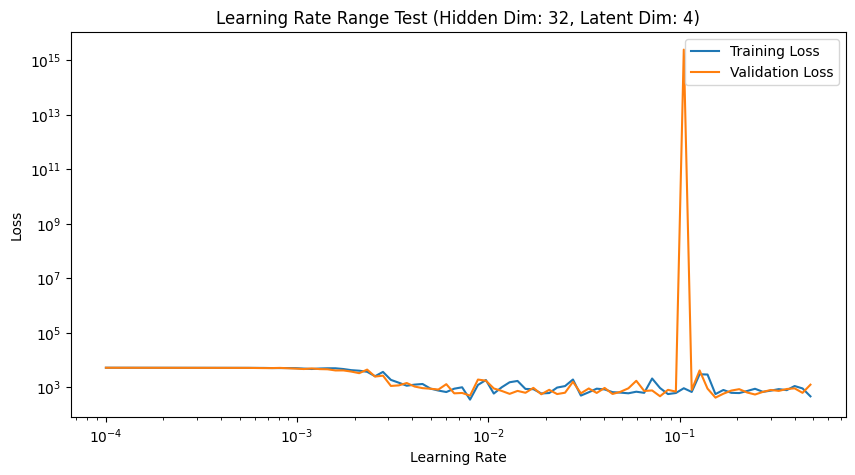


--------------------------------------------------

Lowest validation loss of 429.3327 obtained at learning rate 2.1e-02


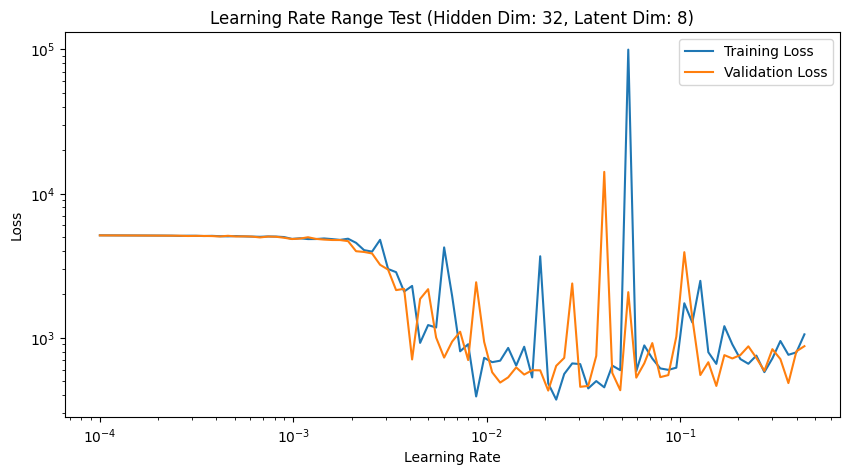


--------------------------------------------------

Lowest validation loss of 395.0430 obtained at learning rate 9.6e-02


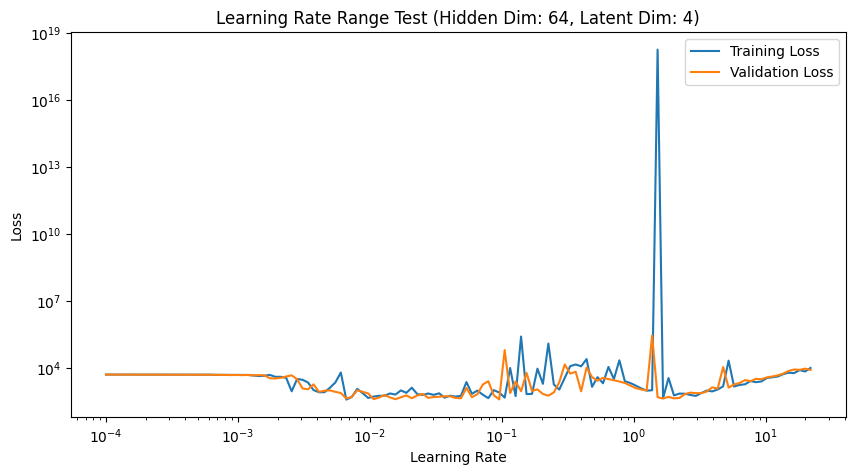


--------------------------------------------------

Lowest validation loss of 358.6461 obtained at learning rate 1.3e-02


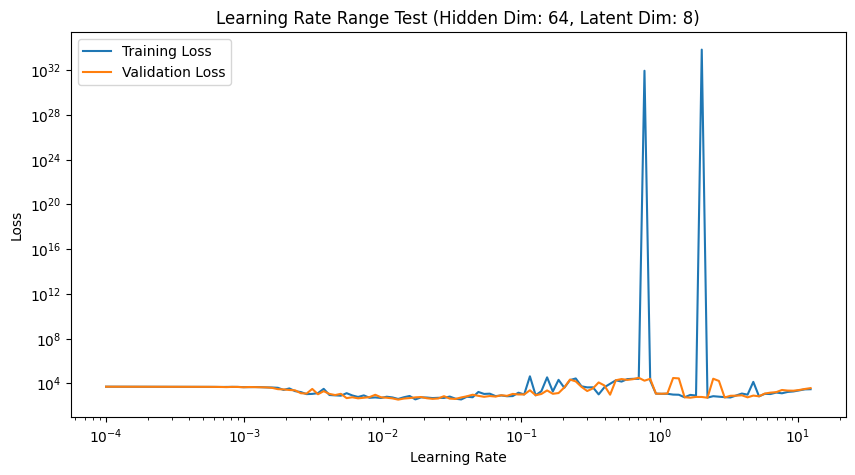


--------------------------------------------------

Lowest validation loss of 407.5691 obtained at learning rate 7.3e-03


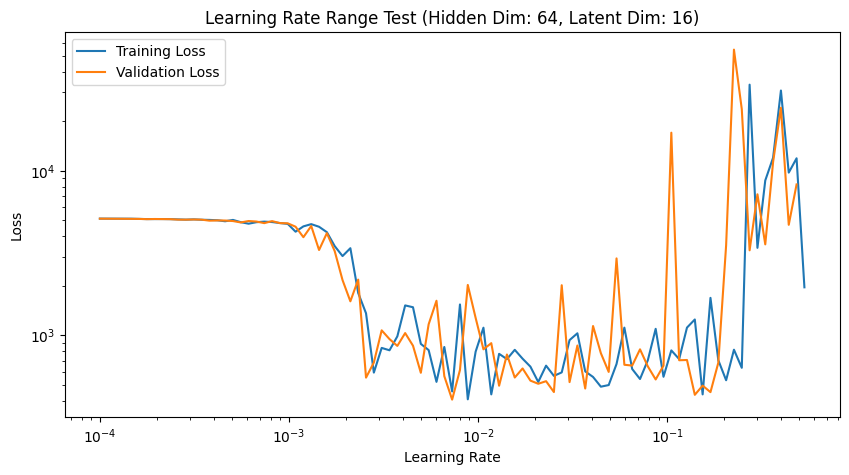


--------------------------------------------------

Lowest validation loss of 393.2560 obtained at learning rate 8.8e-03


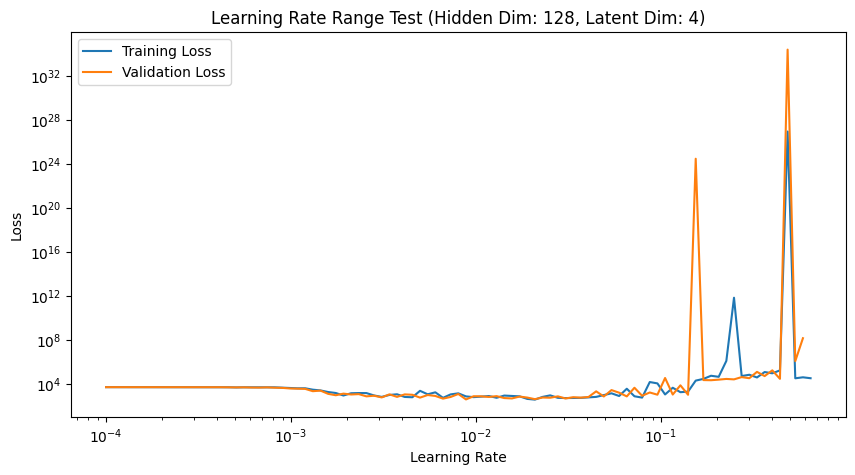


--------------------------------------------------

Lowest validation loss of 395.6845 obtained at learning rate 1.4e-02


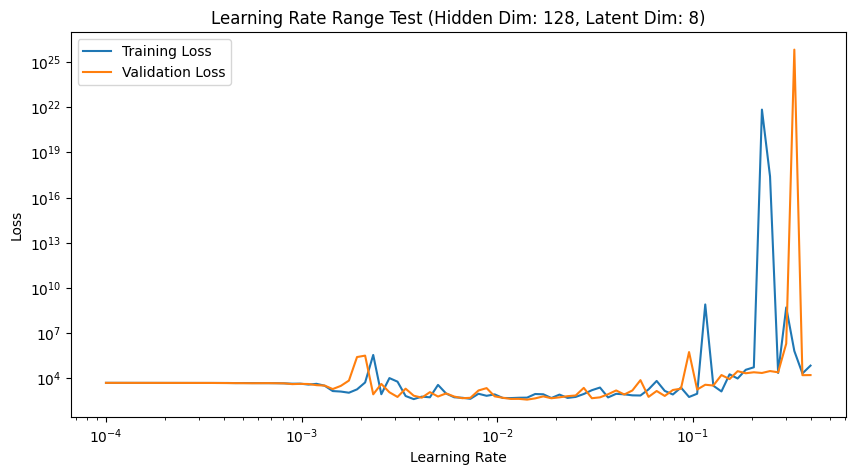


--------------------------------------------------

Lowest validation loss of 329.0708 obtained at learning rate 1.3e-02


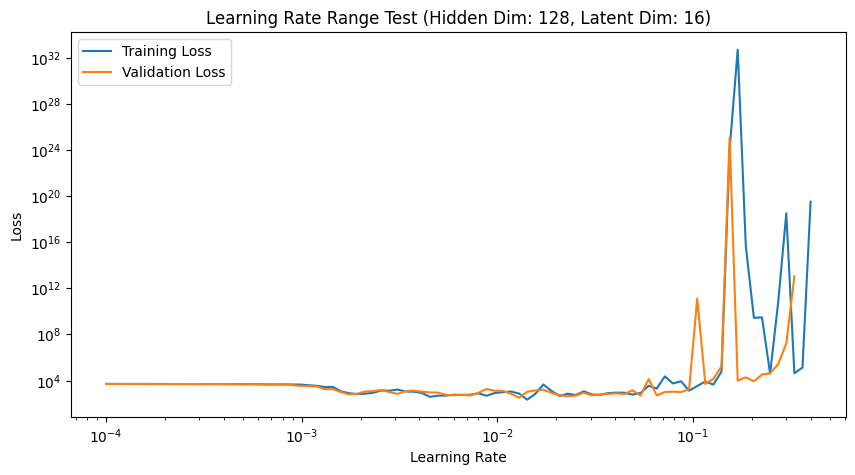


--------------------------------------------------

Lowest validation loss of 495.4407 obtained at learning rate 2.1e-02


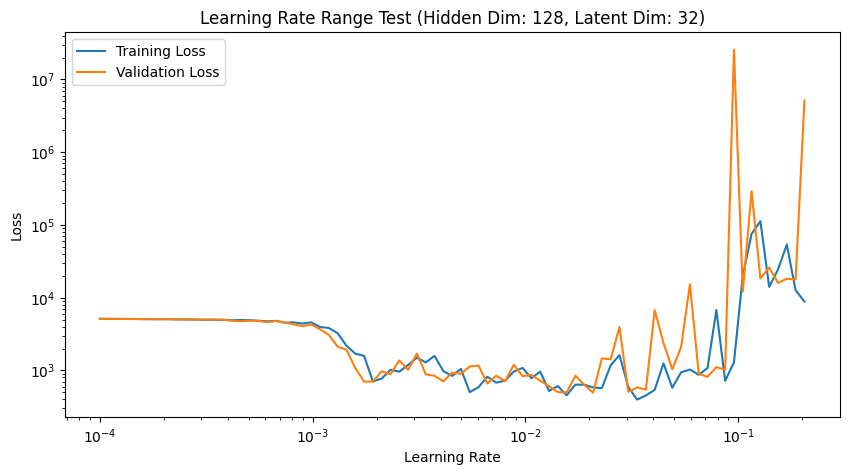


--------------------------------------------------

Lowest validation loss of 381.0768 obtained at learning rate 2.3e-02


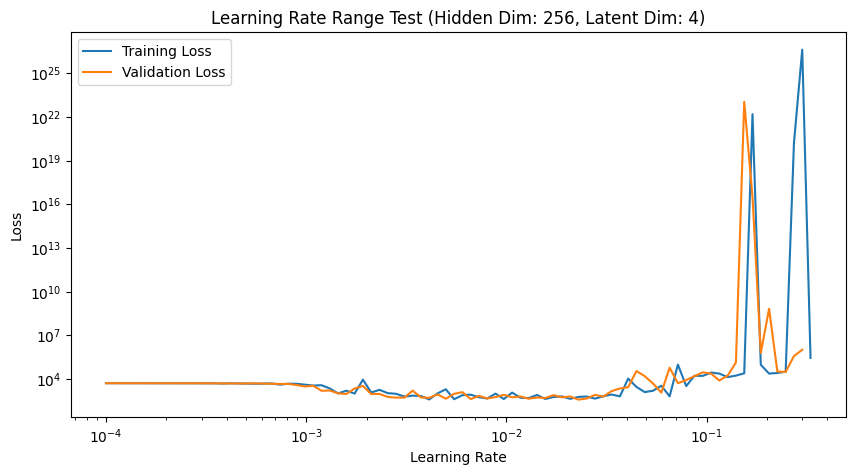


--------------------------------------------------

Lowest validation loss of 452.0431 obtained at learning rate 1.4e-02


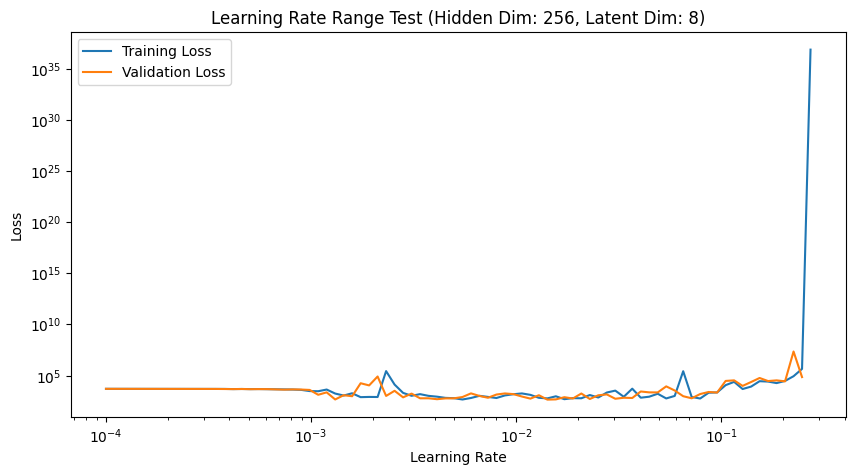


--------------------------------------------------

Lowest validation loss of 334.9128 obtained at learning rate 4.1e-03


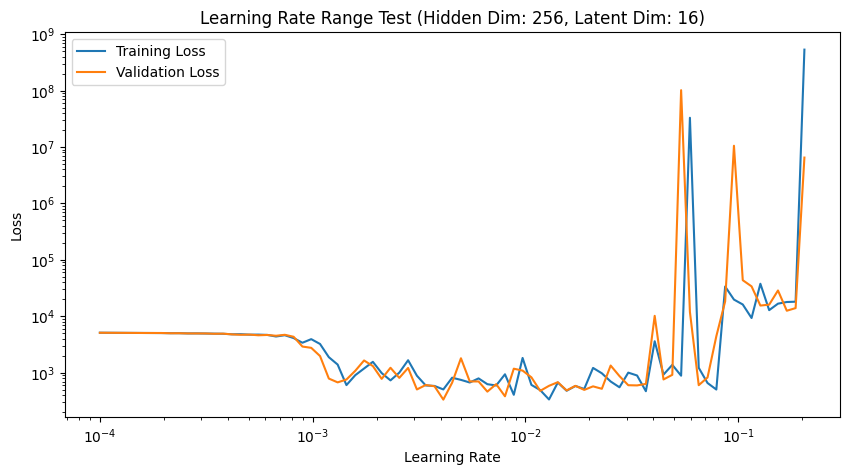


--------------------------------------------------

Lowest validation loss of 420.1630 obtained at learning rate 1.6e-02


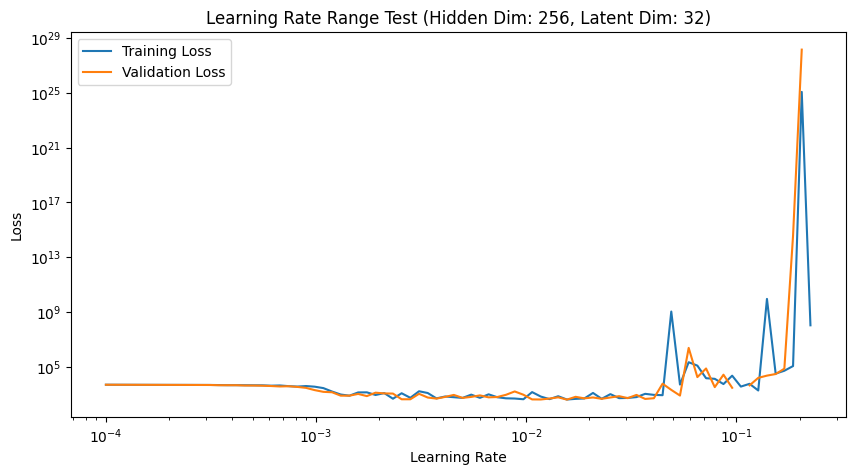


--------------------------------------------------

Lowest validation loss of 374.2574 obtained at learning rate 2.1e-02


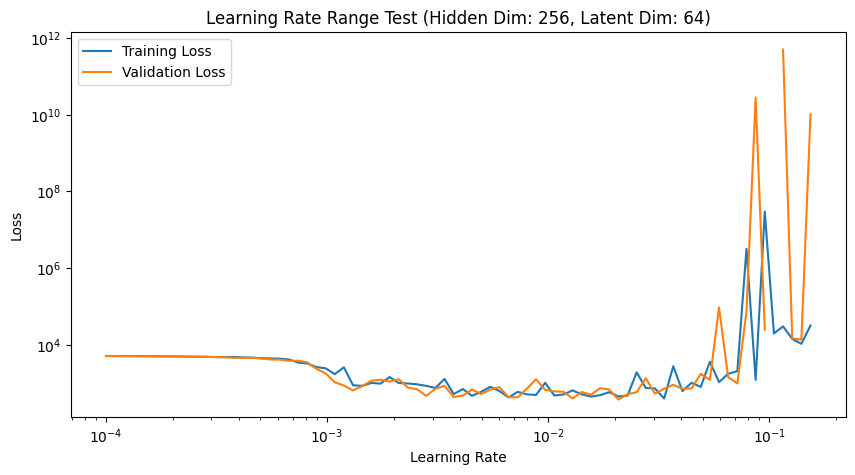


--------------------------------------------------

Lowest validation loss of 370.5900 obtained at learning rate 6.6e-03


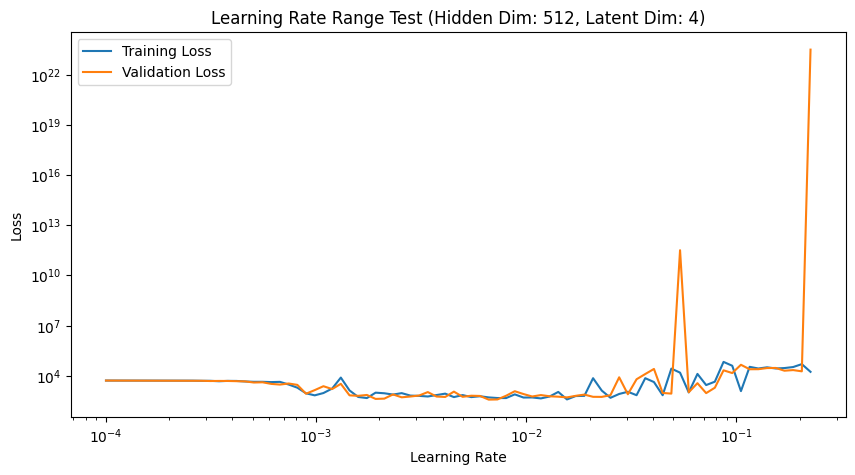


--------------------------------------------------

Lowest validation loss of 371.8204 obtained at learning rate 1.6e-02


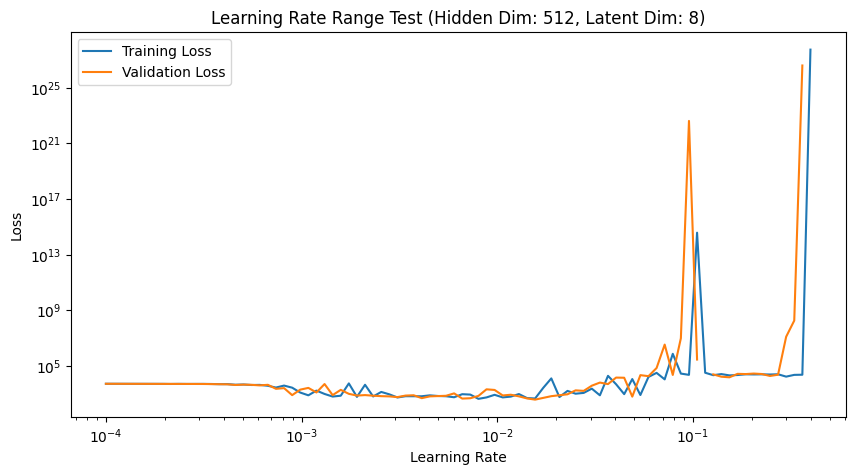


--------------------------------------------------

Lowest validation loss of 343.4336 obtained at learning rate 2.1e-03


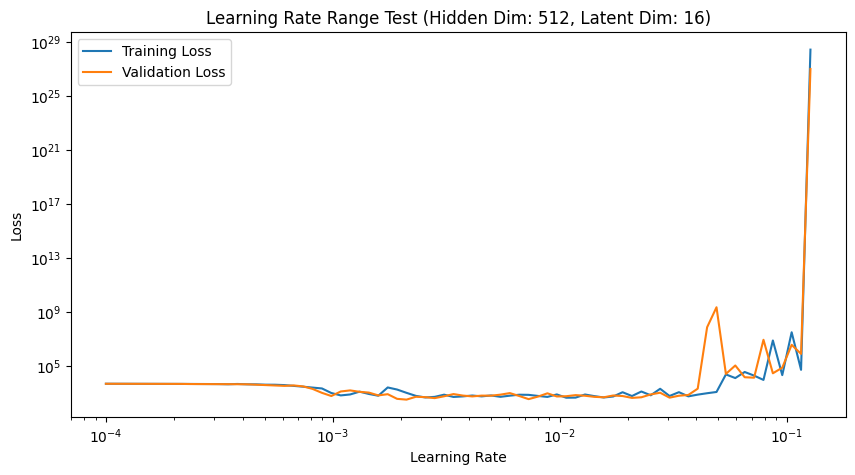


--------------------------------------------------

Lowest validation loss of 382.7885 obtained at learning rate 1.6e-02


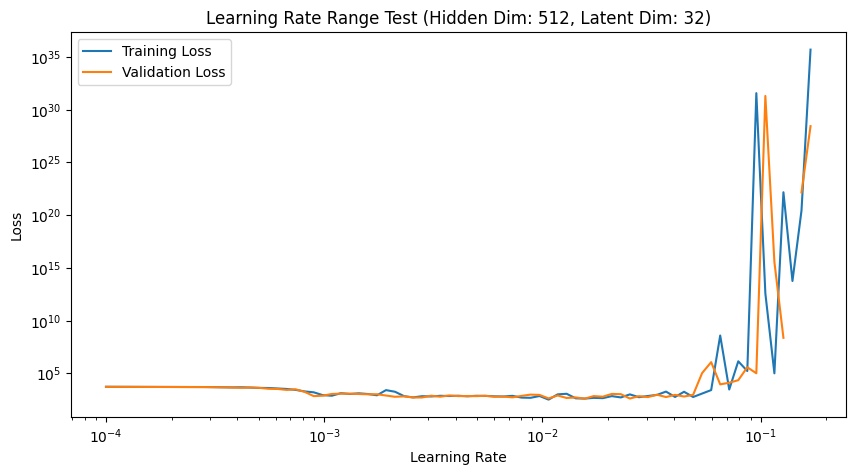


--------------------------------------------------

Lowest validation loss of 394.9346 obtained at learning rate 1.2e-02


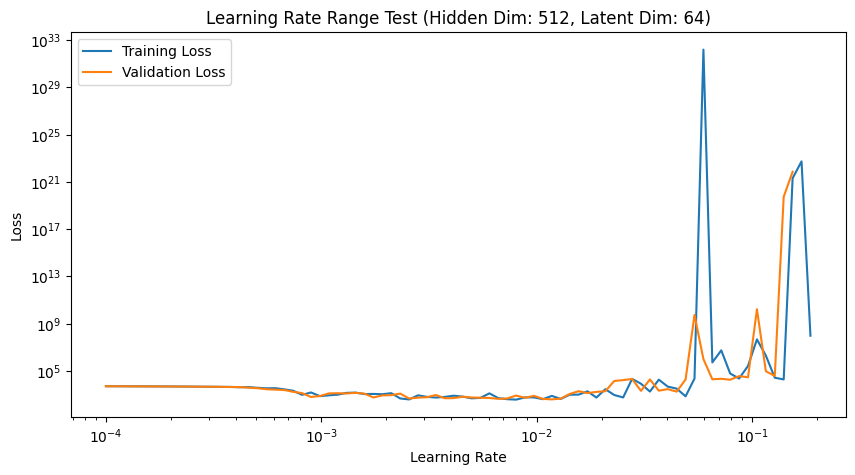


--------------------------------------------------

Lowest validation loss of 323.4944 obtained at learning rate 5.0e-03


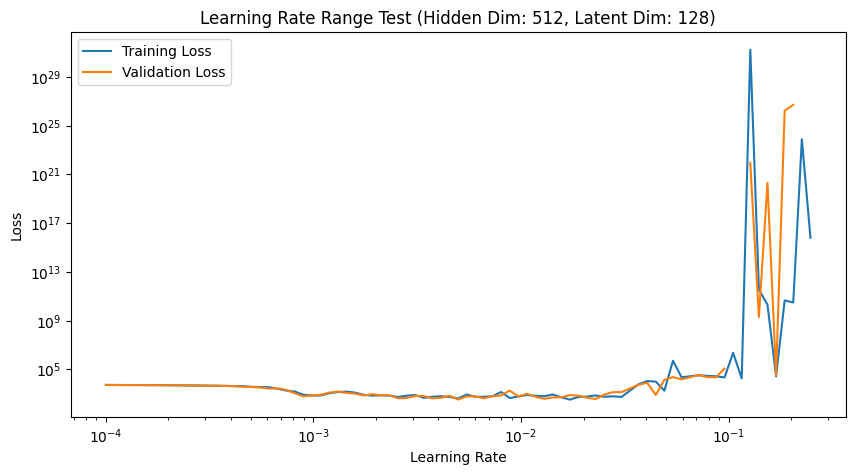


--------------------------------------------------

Lowest validation loss of 403.5374 obtained at learning rate 1.4e-02


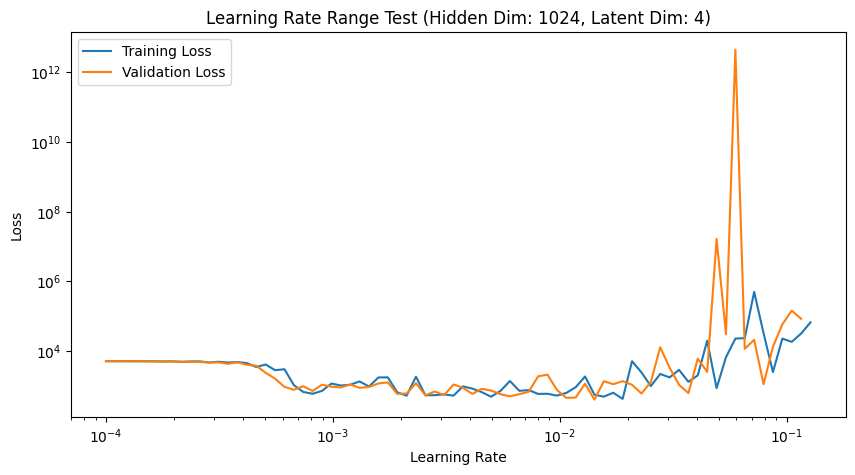


--------------------------------------------------

Lowest validation loss of 405.6496 obtained at learning rate 2.8e-03


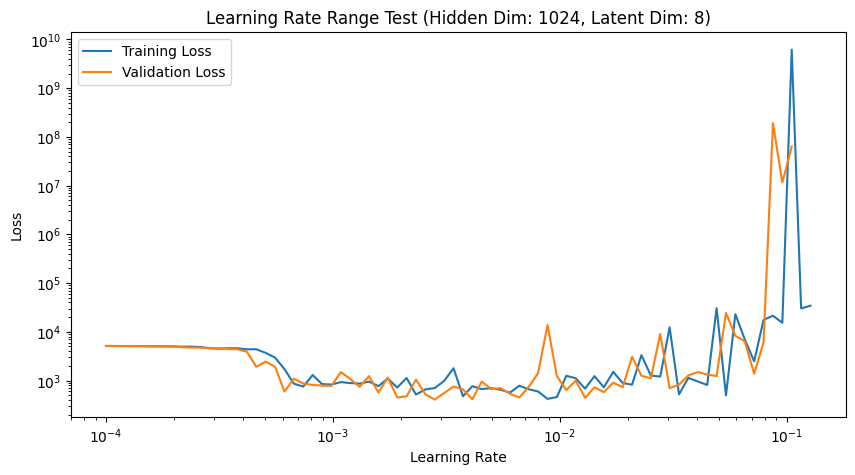


--------------------------------------------------

Lowest validation loss of 460.3093 obtained at learning rate 1.7e-03


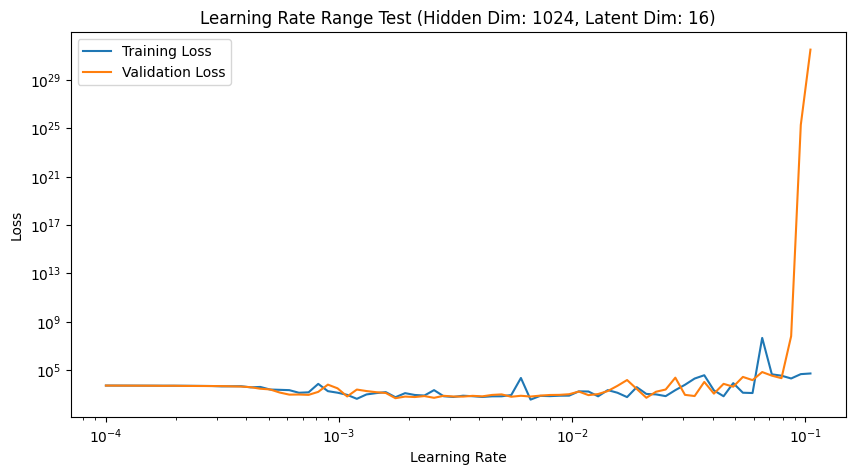


--------------------------------------------------

Lowest validation loss of 323.0703 obtained at learning rate 7.3e-03


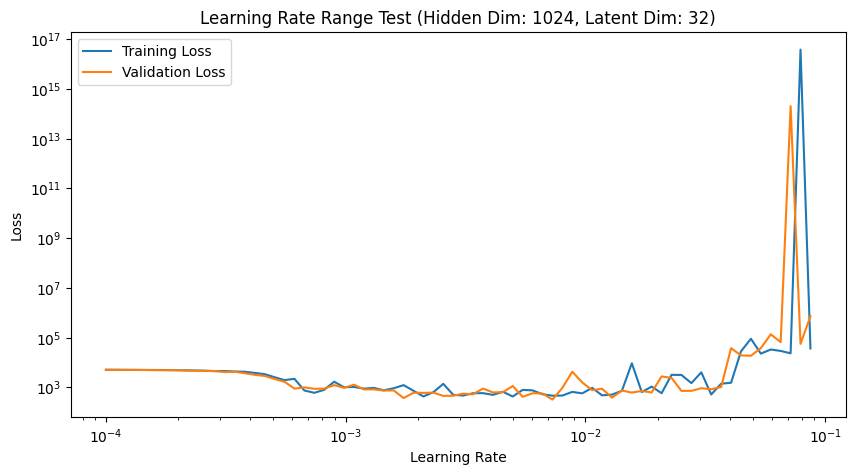


--------------------------------------------------

Lowest validation loss of 399.3404 obtained at learning rate 7.3e-03


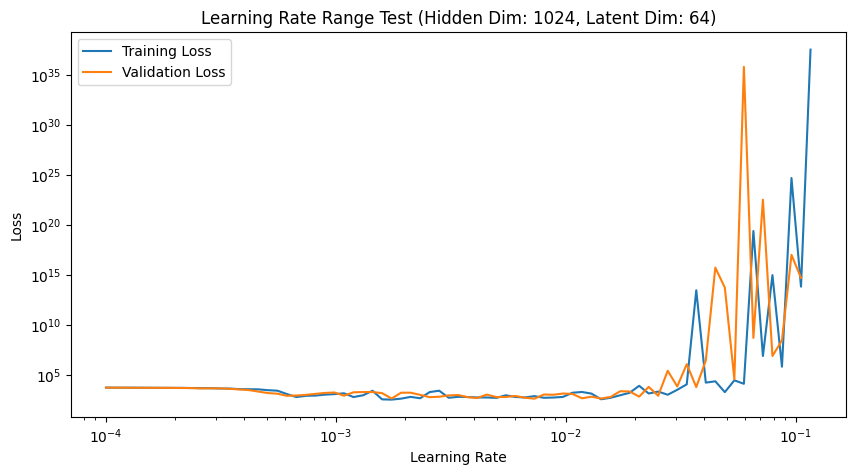


--------------------------------------------------

Lowest validation loss of 416.2258 obtained at learning rate 1.1e-03


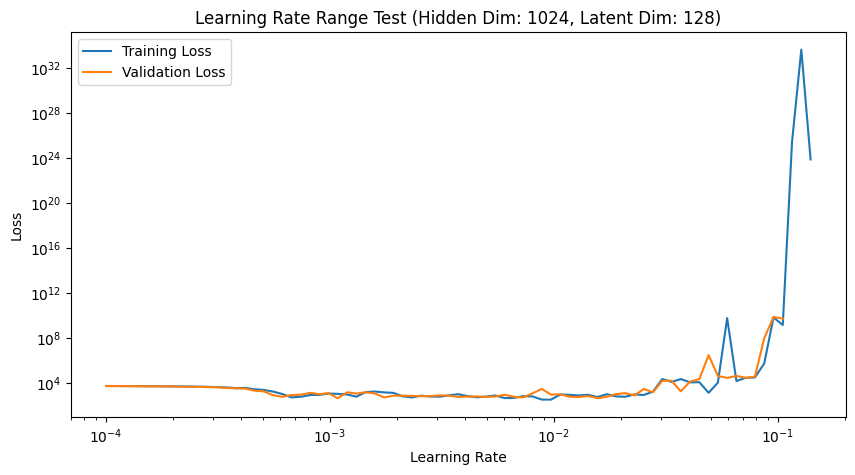


--------------------------------------------------

Lowest validation loss of 391.8723 obtained at learning rate 3.1e-03


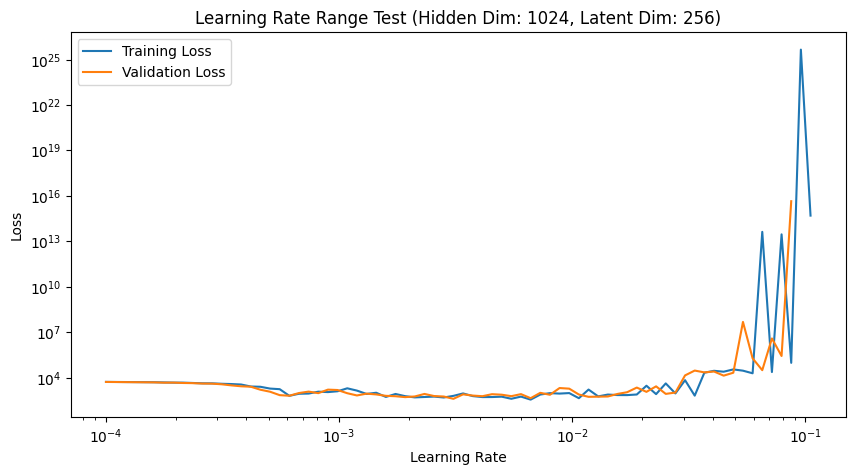


--------------------------------------------------

Lowest validation loss of 418.2380 obtained at learning rate 1.3e-03


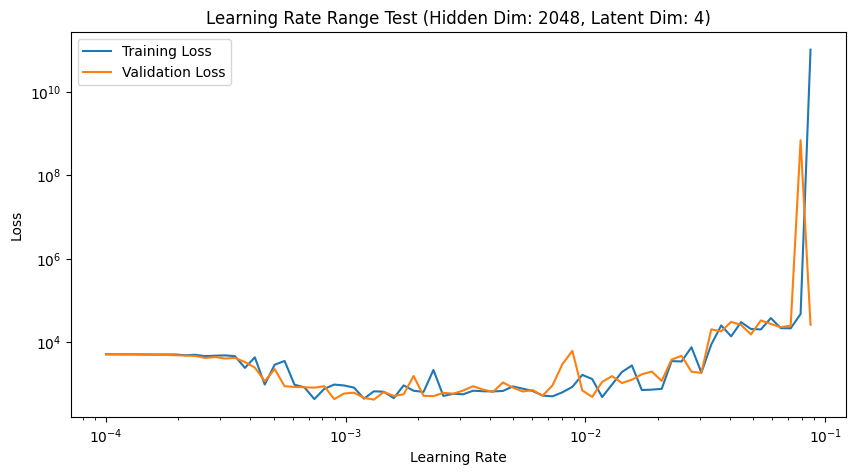


--------------------------------------------------

Lowest validation loss of 318.9659 obtained at learning rate 3.1e-03


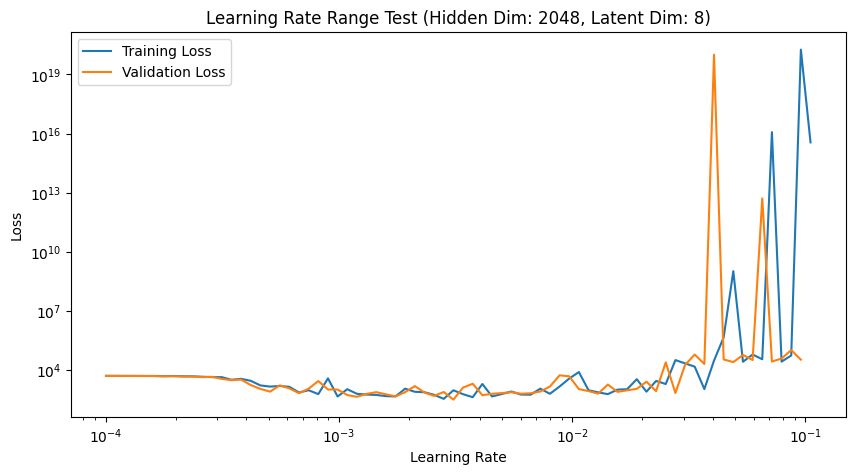


--------------------------------------------------

Lowest validation loss of 387.0021 obtained at learning rate 1.3e-03


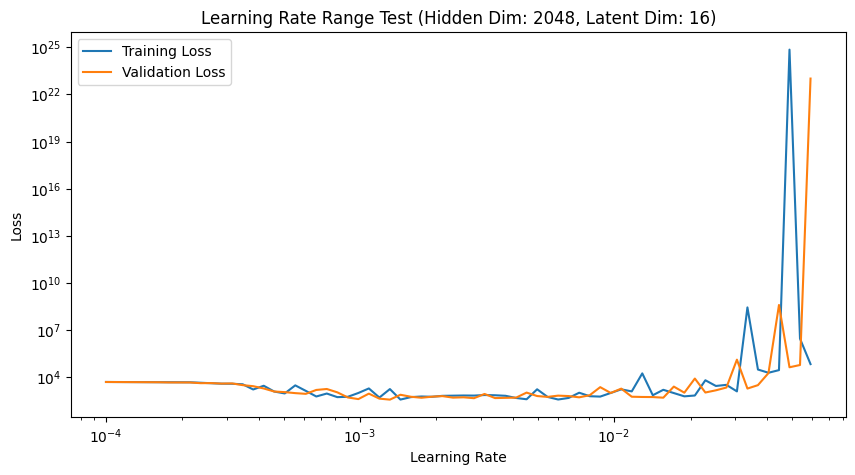


--------------------------------------------------

Lowest validation loss of 245.9599 obtained at learning rate 6.0e-03


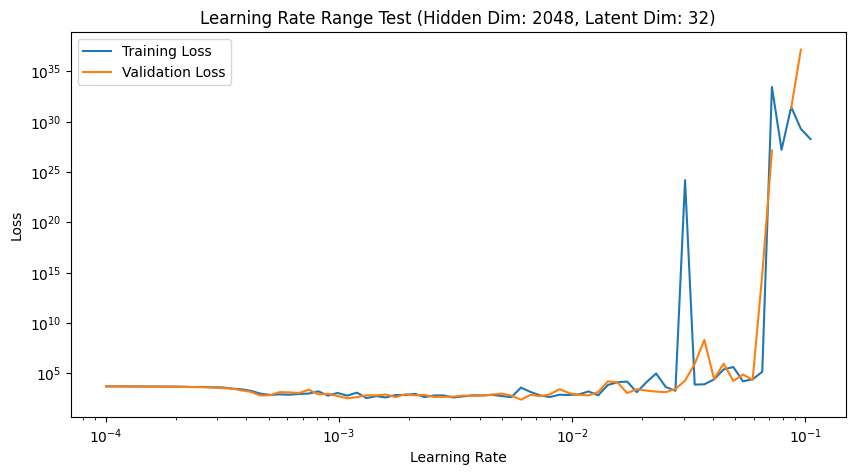


--------------------------------------------------

Lowest validation loss of 399.4364 obtained at learning rate 2.6e-03


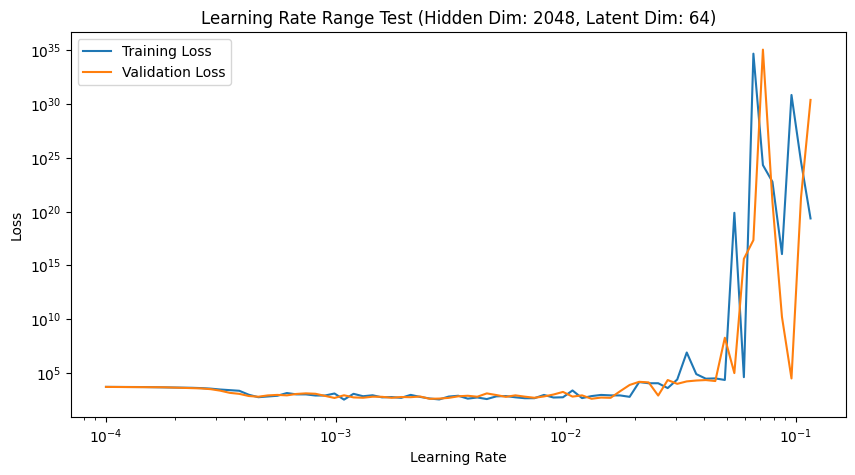


--------------------------------------------------

Lowest validation loss of 390.3501 obtained at learning rate 3.1e-03


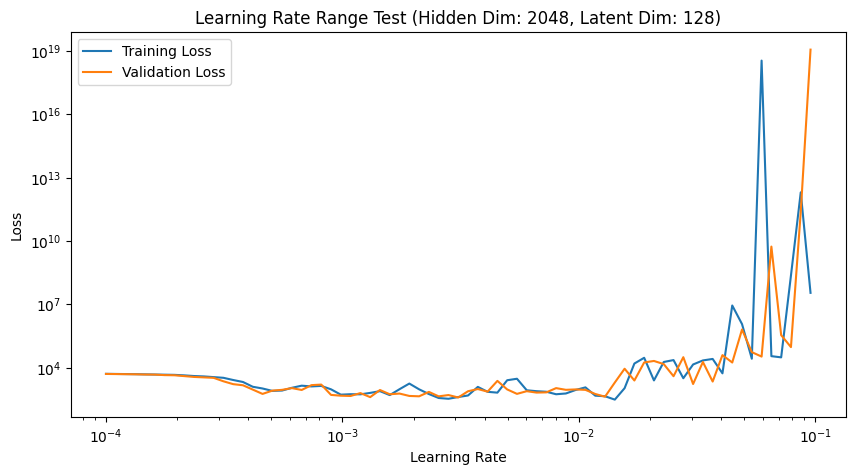


--------------------------------------------------

Lowest validation loss of 334.1299 obtained at learning rate 1.1e-03


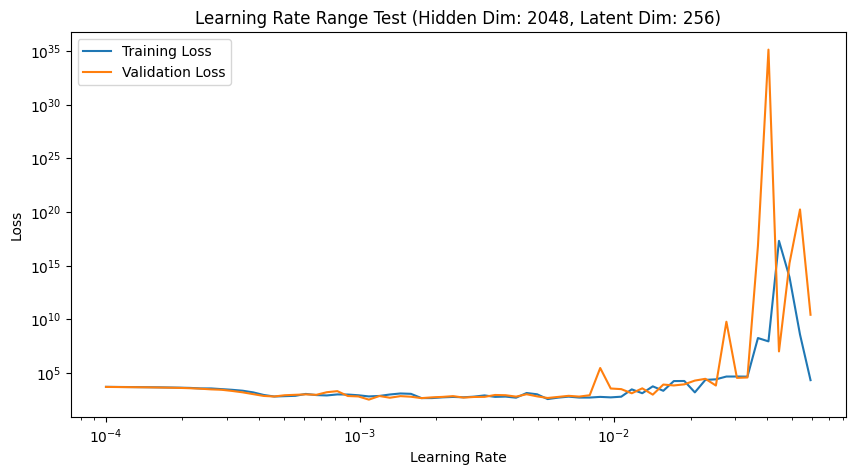


--------------------------------------------------

Lowest validation loss of 365.9765 obtained at learning rate 6.6e-03


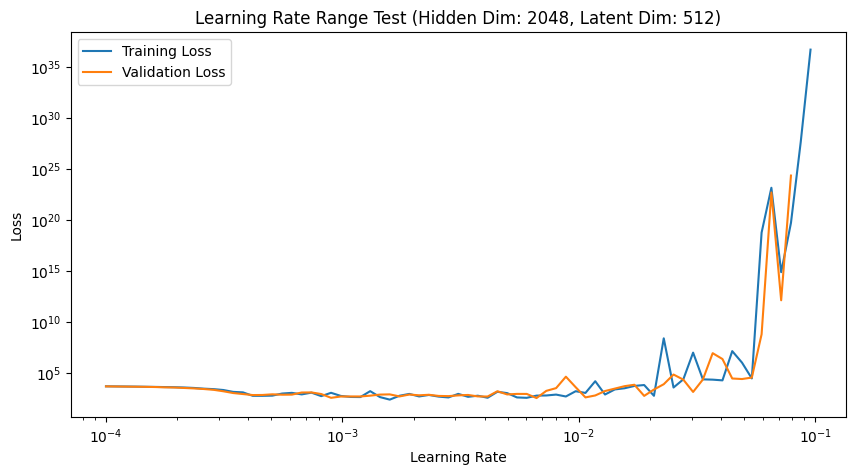


--------------------------------------------------



In [64]:
hidden_layer_sizes = [32, 64, 128, 256, 512, 1024, 2048]
latent_dim_sizes = [4, 8, 16, 32, 64, 128, 256, 512]

best_hidden_dim = None

for hidden_dim in hidden_layer_sizes:
    for latent_dim in latent_dim_sizes:
        if latent_dim == hidden_dim or latent_dim == hidden_dim//2 or latent_dim > hidden_dim:
            continue 
        
        # Instantiate the VAE model
        model = VAE(input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
        model = reset_model_weights(model)

        # Initialize optimizer with a very small learning rate
        initial_lr = 1e-4
        optimizer = optim.Adam(model.parameters(), lr=initial_lr)

        # Initialize lists to store learning rates, training losses, and validation losses
        lrs = []
        train_losses = []
        val_losses = []

        # Initialize variables to store the best loss and corresponding learning rate
        min_val_loss = float('inf')
        best_lr = initial_lr

        # Define the learning rate scheduler to exponentially increase the learning rate
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.1)

        # Number of iterations for the LR range test
        num_iters = 5  # or a reasonable number of iterations

        model.train()
        for iter in range(num_iters):
            for train_batch, val_batch in zip(train_dataloader, val_dataloader):
                # Move batches to GPU
                train_batch = train_batch.to(device)
                val_batch = val_batch.to(device)
                
                optimizer.zero_grad()
                
                # Training phase
                train_outputs, train_mu, train_logvar = model(train_batch)
                train_loss = vae_loss_function(train_outputs, train_batch, train_mu, train_logvar)
                train_loss.backward()
                optimizer.step()
                
                # Validation phase
                model.eval()  # switch to evaluation mode
                with torch.no_grad():
                    val_outputs, val_mu, val_logvar = model(val_batch)
                    val_loss = vae_loss_function(val_outputs, val_batch, val_mu, val_logvar)
                
                # Record the current learning rate and losses
                current_lr = optimizer.param_groups[0]['lr']
                lrs.append(current_lr)
                train_losses.append(train_loss.item())
                val_losses.append(val_loss.item())
                
                # Check for the minimum validation loss and corresponding learning rate
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    best_lr = current_lr
                
                # Step the learning rate scheduler
                scheduler.step()
                
                # Print progress
                #print(f"Iter {iter+1}/{num_iters}, LR: {current_lr:.1e}, Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}")

        print(f"Lowest validation loss of {min_val_loss:.4f} obtained at learning rate {best_lr:.1e}")
        # Plot the learning rate range test
        plt.figure(figsize=(10, 5))
        plt.plot(lrs, train_losses, label='Training Loss')
        plt.plot(lrs, val_losses, label='Validation Loss')
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.yscale('log')
        plt.ylabel('Loss')
        plt.title(f'Learning Rate Range Test (Hidden Dim: {hidden_dim}, Latent Dim: {latent_dim})')
        plt.legend()
        plt.show()
        print('\n' + '-' * 50 + '\n')


In [11]:
def generate_model(model, optimizer, num_epochs=300, patience=50, output_model_path='vae.pth'):
    # Initialize lists to store losses
    train_losses = []
    test_losses = []

    best_loss = float('inf')  # Initialize best loss to positive infinity
    best_epoch = 0  # Initialize the epoch at which the best loss occurred

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch in train_dataloader:
            # Move batch to GPU
            batch = batch.to(device)
            
            optimizer.zero_grad()
            outputs, mu, logvar = model(batch)
            loss = vae_loss_function(outputs, batch, mu, logvar)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        average_train_loss = train_loss / len(train_dataloader)
        train_losses.append(average_train_loss)

        # Evaluate Model
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_dataloader:
                batch = batch.to(device)
                outputs, mu, logvar = model(batch)
                test_loss += vae_loss_function(outputs, batch, mu, logvar).item()

        average_test_loss = test_loss / len(test_dataloader)
        test_losses.append(average_test_loss)

        print(f"Epoch {epoch+1}, Average Train Loss: {average_train_loss}, Average Test Loss: {average_test_loss}")

        # Check if the current test loss is the best so far
        if average_test_loss < best_loss:
            best_loss = average_test_loss
            best_epoch = epoch
            # Save the best model
            torch.save(model.state_dict(), output_model_path)

        # Check for early stopping criterion
        if epoch - best_epoch >= patience:
            print(f"No improvement in test loss for {patience} epochs. Early stopping.")
            break
        
    return train_losses, test_losses

In [66]:
tiny_model = VAE(input_dim, latent_dim=4, hidden_dim=32).to(device)
tiny_lr = 1.7e-02
tiny_optimizer = optim.Adam(tiny_model.parameters(), lr=tiny_lr)

normal_model = VAE(input_dim, latent_dim=64, hidden_dim=512).to(device)
normal_lr = 7.3e-03
normal_optimizer = optim.Adam(normal_model.parameters(), lr=normal_lr)

large_model = VAE(input_dim, latent_dim=256, hidden_dim=2048).to(device)
large_lr = 5.0e-03
large_optimizer = optim.Adam(large_model.parameters(), lr=large_lr)

In [67]:
tiny_train_losses , tiny_test_losses = generate_model(tiny_model, tiny_optimizer, 300, 50, "tiny_vae.pth")
large_train_losses, large_test_losses = generate_model(large_model, large_optimizer, 300, 50, "large_vae.pth")
normal_train_losses, normal_test_losses = generate_model(normal_model, normal_optimizer, 300, 50, "normal_vae.pth")

Epoch 1, Average Train Loss: 580.7587397922979, Average Test Loss: 485.7471727643694
Epoch 2, Average Train Loss: 397.94396231107623, Average Test Loss: 409.71083177839006
Epoch 3, Average Train Loss: 408.2471906002437, Average Test Loss: 416.8194476536342
Epoch 4, Average Train Loss: 356.5629109177634, Average Test Loss: 374.6846411568778
Epoch 5, Average Train Loss: 359.00182912951317, Average Test Loss: 443.6568276541574
Epoch 6, Average Train Loss: 360.9797300534828, Average Test Loss: 375.7881954738072
Epoch 7, Average Train Loss: 337.82322001234394, Average Test Loss: 365.61261204310824
Epoch 8, Average Train Loss: 334.93211821083713, Average Test Loss: 351.9156156267439
Epoch 9, Average Train Loss: 328.18570737749616, Average Test Loss: 361.9334863935198
Epoch 10, Average Train Loss: 323.59287696909684, Average Test Loss: 356.95963505336215
Epoch 11, Average Train Loss: 327.46629960960314, Average Test Loss: 362.9335953848703
Epoch 12, Average Train Loss: 329.26197066262506, Ave

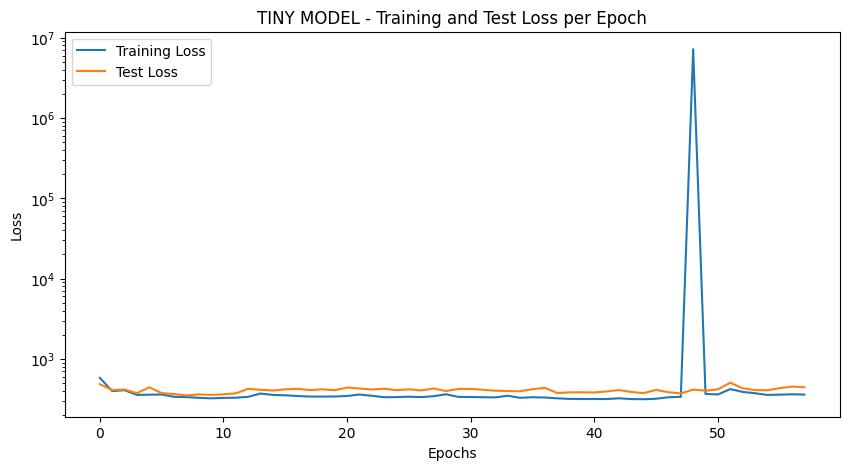

In [68]:
# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(tiny_train_losses, label='Training Loss')
plt.plot(tiny_test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('TINY MODEL - Training and Test Loss per Epoch')
plt.show()

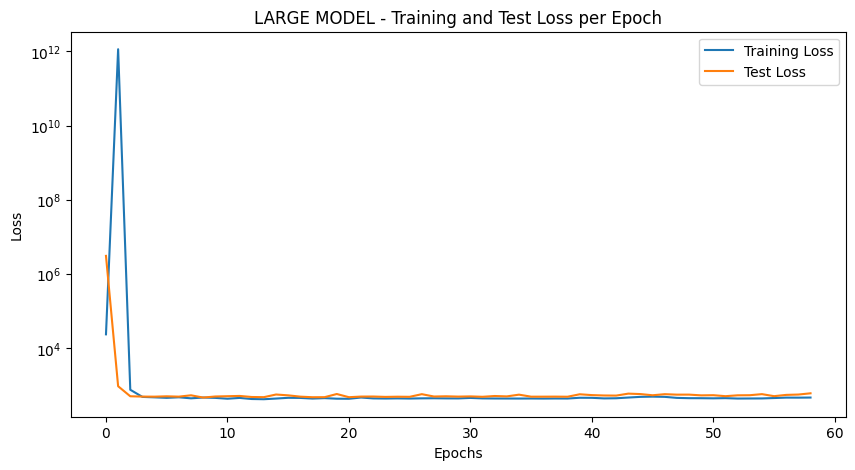

In [69]:
# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(large_train_losses, label='Training Loss')
plt.plot(large_test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('LARGE MODEL - Training and Test Loss per Epoch')
plt.show()

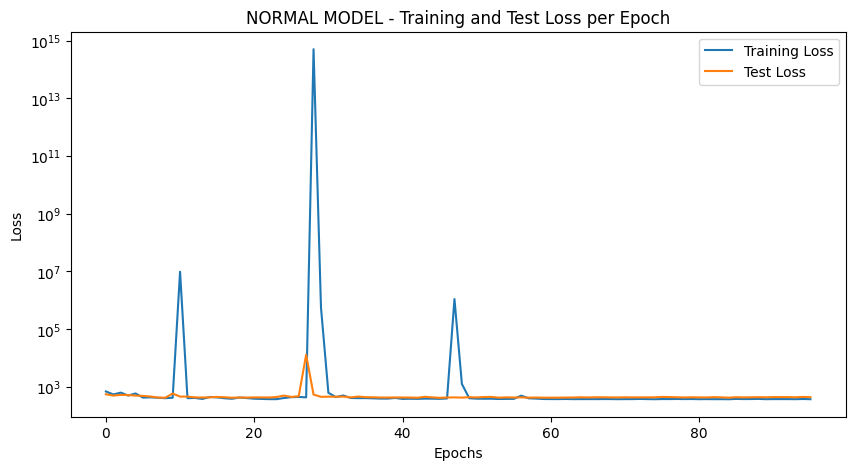

In [70]:
# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(normal_train_losses, label='Training Loss')
plt.plot(normal_test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('NORMAL MODEL - Training and Test Loss per Epoch')
plt.show()

In [16]:
tile_set = load_tile_set()
len(tile_set) # should be 42

42

In [72]:
tiny_model = VAE(input_dim, latent_dim=4, hidden_dim=32).to(device)
tiny_model.load_state_dict(torch.load('tiny_vae.pth'))

normal_model = VAE(input_dim, latent_dim=64, hidden_dim=512).to(device)
normal_model.load_state_dict(torch.load('normal_vae.pth'))

large_model = VAE(input_dim, latent_dim=256, hidden_dim=2048).to(device)
large_model.load_state_dict(torch.load('large_vae.pth'))

<All keys matched successfully>

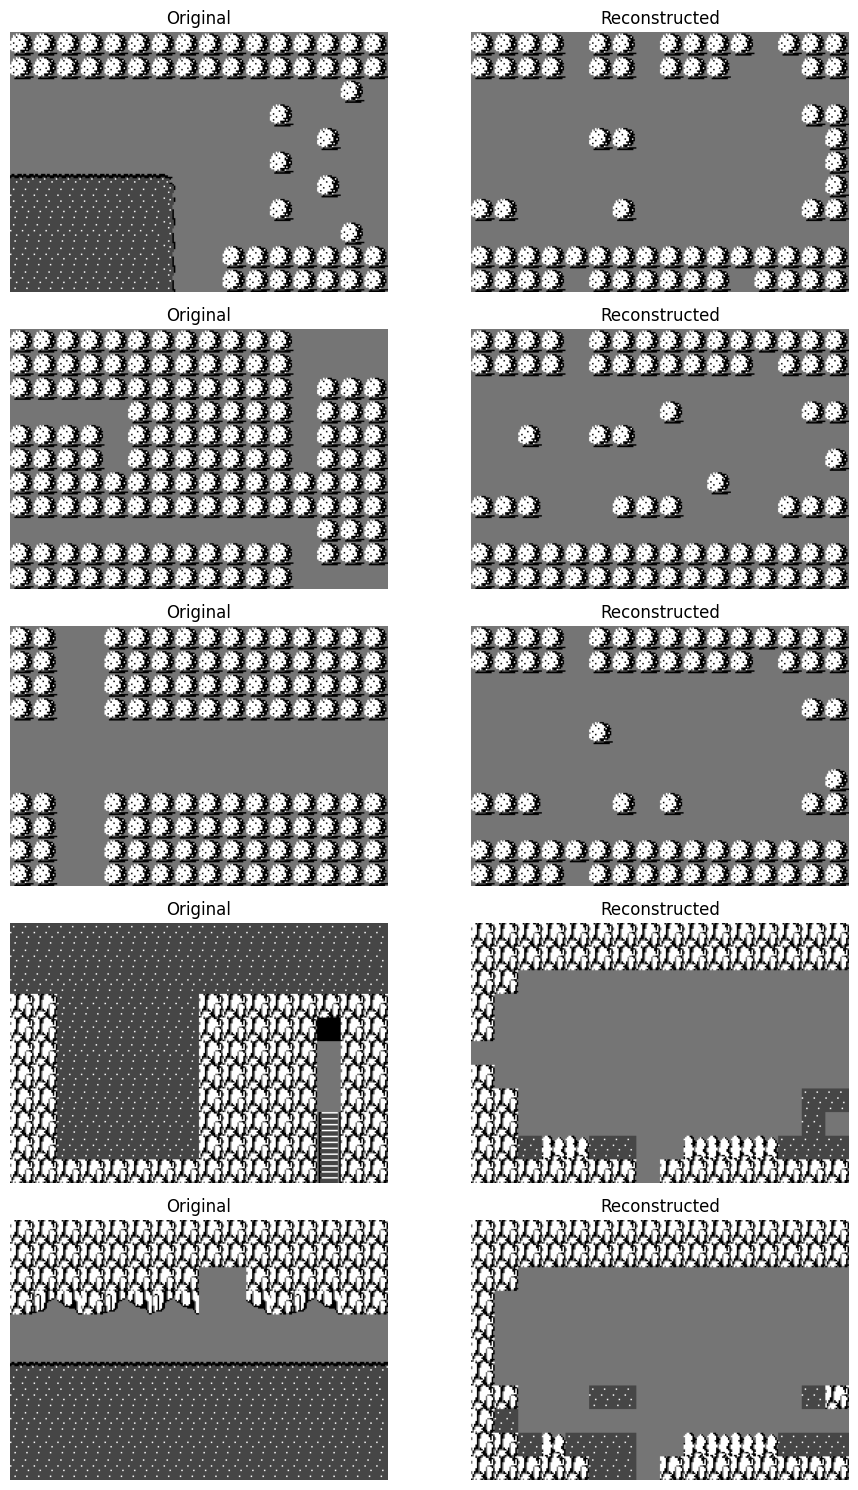

In [73]:
# Pass some test images through the VAE model to get reconstructed images
original_images = []
reconstructed_images = []

# Set the best VAE model to evaluation mode
tiny_model.eval()

# Pass test batches through the best VAE model
with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to GPU and convert to torch.float32
        batch = batch.to(torch.float32).to(device)
        
        # Forward pass using the best VAE model
        outputs, _, _ = tiny_model(batch)
        
        # Append original and reconstructed images to lists
        original_images.append(batch.cpu())  # Move back to CPU for visualization
        reconstructed_images.append(outputs.cpu())  # Move back to CPU for visualization

# Concatenate lists of tensors into single tensors
original_images = torch.cat(original_images, dim=0)
reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Plot the original and reconstructed images
plot_images(original_images, reconstructed_images, tile_set, 16)


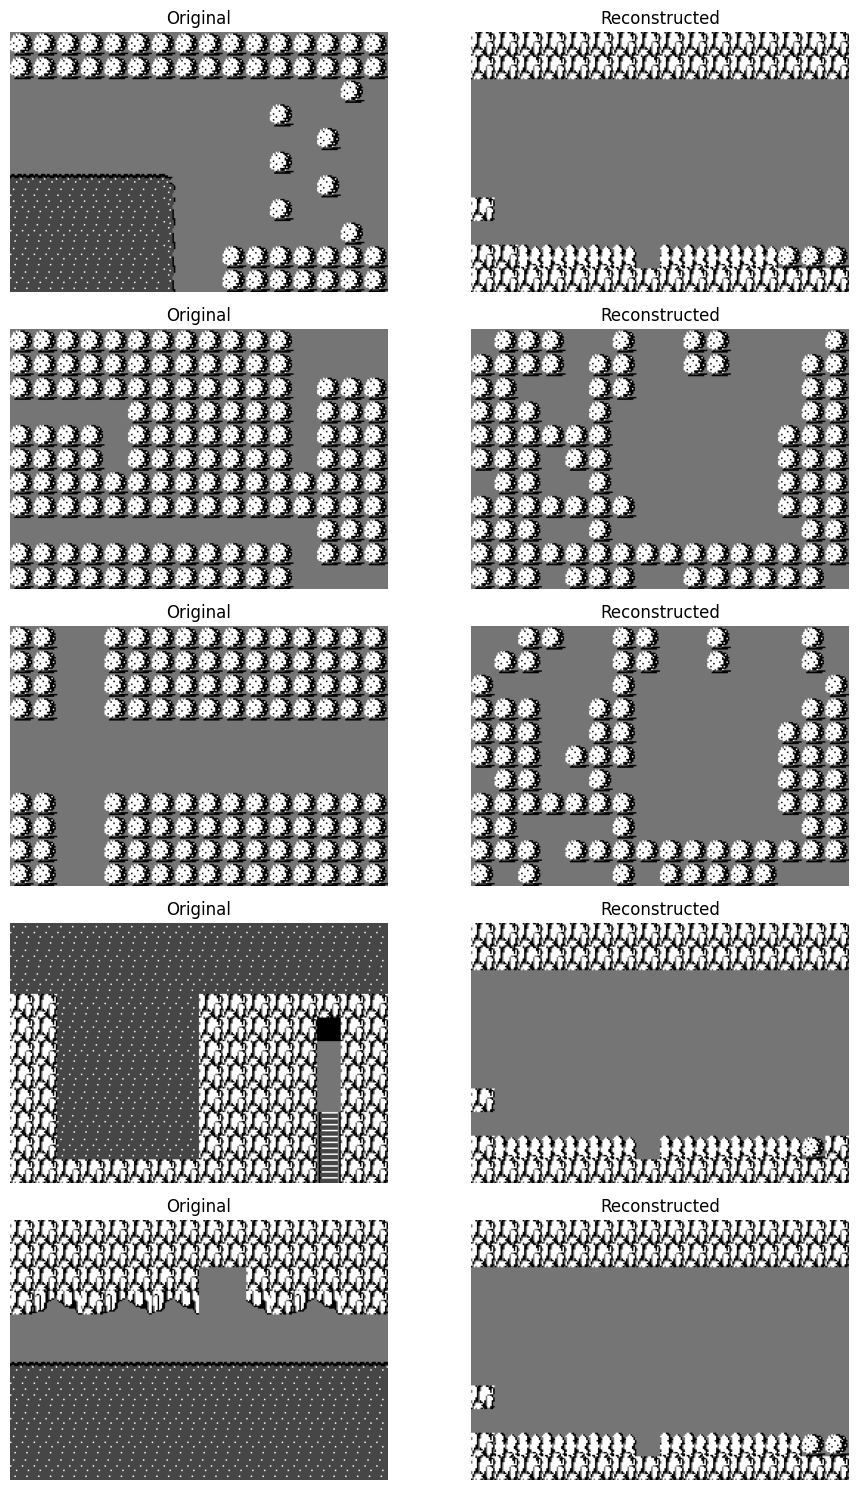

In [74]:
# Pass some test images through the VAE model to get reconstructed images
original_images = []
reconstructed_images = []

# Set the best VAE model to evaluation mode
large_model.eval()

# Pass test batches through the best VAE model
with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to GPU and convert to torch.float32
        batch = batch.to(torch.float32).to(device)
        
        # Forward pass using the best VAE model
        outputs, _, _ = large_model(batch)
        
        # Append original and reconstructed images to lists
        original_images.append(batch.cpu())  # Move back to CPU for visualization
        reconstructed_images.append(outputs.cpu())  # Move back to CPU for visualization

# Concatenate lists of tensors into single tensors
original_images = torch.cat(original_images, dim=0)
reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Plot the original and reconstructed images
plot_images(original_images, reconstructed_images, tile_set, 16)



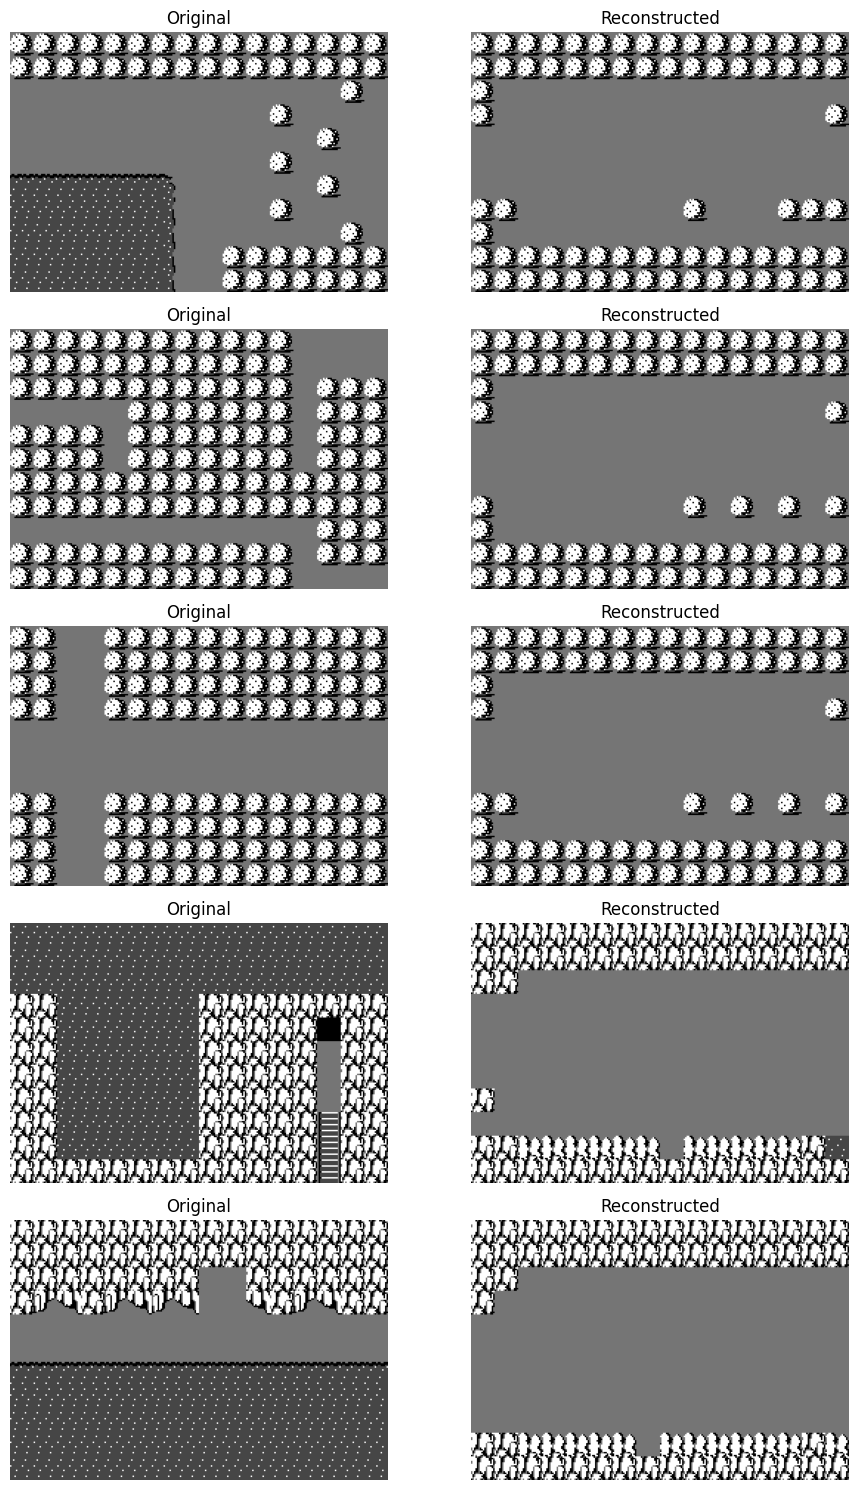

In [75]:
# Pass some test images through the VAE model to get reconstructed images
original_images = []
reconstructed_images = []

# Set the best VAE model to evaluation mode
normal_model.eval()

# Pass test batches through the best VAE model
with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to GPU and convert to torch.float32
        batch = batch.to(torch.float32).to(device)
        
        # Forward pass using the best VAE model
        outputs, _, _ = normal_model(batch)
        
        # Append original and reconstructed images to lists
        original_images.append(batch.cpu())  # Move back to CPU for visualization
        reconstructed_images.append(outputs.cpu())  # Move back to CPU for visualization

# Concatenate lists of tensors into single tensors
original_images = torch.cat(original_images, dim=0)
reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Plot the original and reconstructed images
plot_images(original_images, reconstructed_images, tile_set, 16)

In [13]:
mono_model = miniVAE(input_dim, latent_dim=64, hidden_dim=512).to(device)
mono_lr = 0.001
mono_optimizer = optim.Adam(mono_model.parameters(), lr=mono_lr)

In [14]:
mono_train_losses , mono_test_losses = generate_model(mono_model, mono_optimizer, 300, 50, "mono_vae.pth")

Epoch 1, Average Train Loss: 665.1556084891346, Average Test Loss: 357.0528651646205
Epoch 2, Average Train Loss: 324.5349883320176, Average Test Loss: 301.3710844857352
Epoch 3, Average Train Loss: 275.98695330753503, Average Test Loss: 261.64289937700545
Epoch 4, Average Train Loss: 261.32617012808254, Average Test Loss: 267.17575563703264
Epoch 5, Average Train Loss: 241.1962016453253, Average Test Loss: 259.13949748447965
Epoch 6, Average Train Loss: 232.5459971918124, Average Test Loss: 253.198579788208
Epoch 7, Average Train Loss: 223.4469272934388, Average Test Loss: 249.6371203831264
Epoch 8, Average Train Loss: 213.73420494293498, Average Test Loss: 244.32651901245117
Epoch 9, Average Train Loss: 198.65398991664995, Average Test Loss: 241.16301345825195
Epoch 10, Average Train Loss: 193.06427208731108, Average Test Loss: 230.15221323285783
Epoch 11, Average Train Loss: 185.84387210596387, Average Test Loss: 247.92827769688196
Epoch 12, Average Train Loss: 179.61778590835144, A

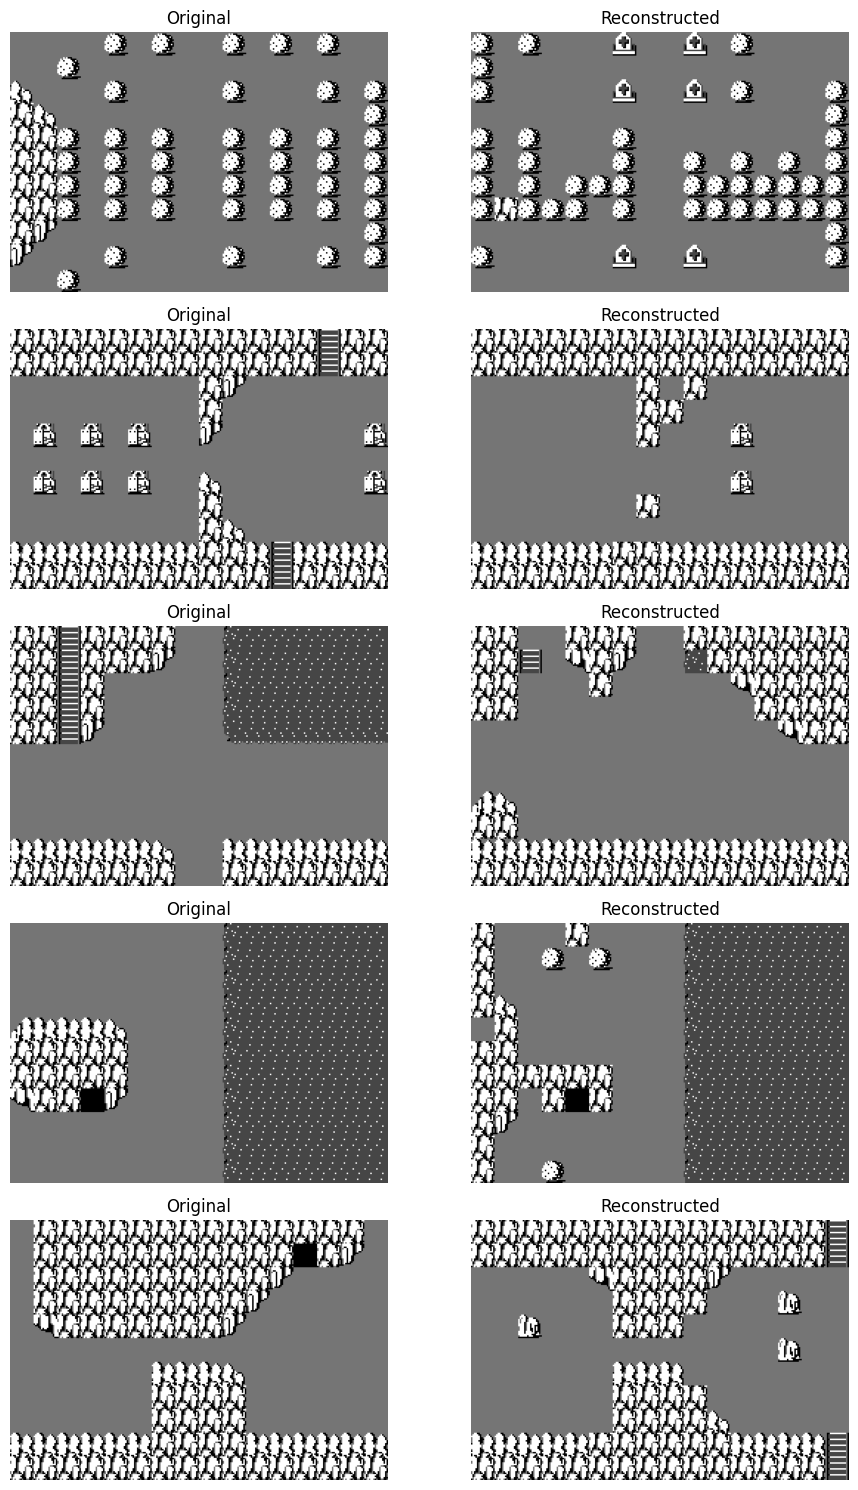

In [17]:
# Pass some test images through the VAE model to get reconstructed images
original_images = []
reconstructed_images = []

# Set the best VAE model to evaluation mode
mono_model.eval()

# Pass test batches through the best VAE model
with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to GPU and convert to torch.float32
        batch = batch.to(torch.float32).to(device)
        
        # Forward pass using the best VAE model
        outputs, _, _ = mono_model(batch)
        
        # Append original and reconstructed images to lists
        original_images.append(batch.cpu())  # Move back to CPU for visualization
        reconstructed_images.append(outputs.cpu())  # Move back to CPU for visualization

# Concatenate lists of tensors into single tensors
original_images = torch.cat(original_images, dim=0)
reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Plot the original and reconstructed images
plot_images(original_images, reconstructed_images, tile_set, 16)

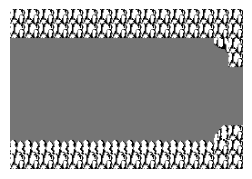

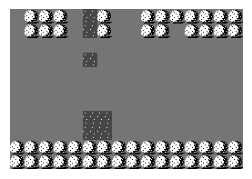

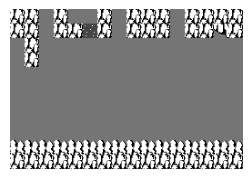

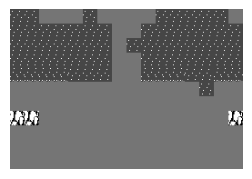

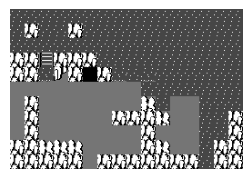

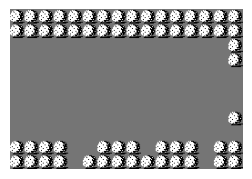

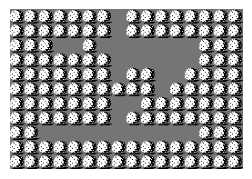

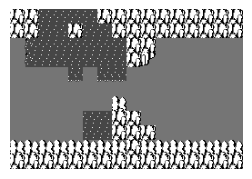

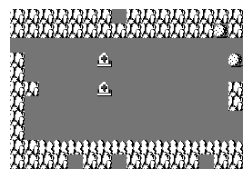

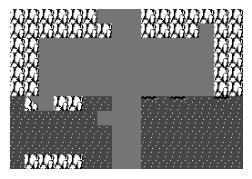

In [15]:
latent_dim = 8
tile_size = 16
tiny_vae = VAE(input_dim, latent_dim=8, hidden_dim=64).to(device)
tiny_vae.load_state_dict(torch.load('tiny_vae.pth'))

# Set the VAE model to evaluation mode
tiny_vae.eval()

# Number of samples to generate
num_samples = 10

# Generate random samples from a standard normal distribution
z_samples = torch.randn(num_samples, latent_dim).to(device)

# Decode the samples
with torch.no_grad():
    generated_samples = tiny_vae.decode(z_samples)

# Convert the generated samples back to numpy arrays
generated_samples = generated_samples.cpu().numpy()
generated_samples_reshaped = generated_samples.reshape(num_samples, 11, 16, 42)

# output_dir = "generated_sample"
# os.makedirs(output_dir, exist_ok=True)

for idx, sample in enumerate(generated_samples_reshaped):
    plt.figure(figsize=(3, 3))
    image = convert_embedding_to_image(sample, tile_set, tile_size)
    # npy_path = os.path.join(output_dir, f'sample_{idx}.npy')
    # np.save(npy_path, sample)
    if idx < 10:
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()